In [ ]:
# default_exp core.classify

In [ ]:
#hide
from nbdev.showdoc import *


# Sneaker Finder 

## Features module - "core.classify"


# OVERVIEW

This is a project initiated while an Insight Data Science fellow.  It grew out of my interest in making data driven tools in the fashion/retail space I had most recently been working.   The original over-scoped idea was to make a shoe desighn tool which could quickly develop some initial sneakers based on choosing some examples, and some text descriptors.  Designs are constrained by the "latent space" defined (discovered?) by a database of shoe images.  However, given the 3 week sprint allowed for development, I pared the tool down to a simple "aesthetic" recommender for sneakers, using the same idea of utilizing an embedding space defined by the database fo shoe images.


Feature extractor: 
    1. embed database into feature space.
    2. evaluate/validate by simple logistic regression on classification.



## A: logistic regression on  feature extractor


## B: transfer learning with classifying "head"


In [ ]:
#hide
from fastbook import *
from fastai.vision.all import *


config = Config()

In [ ]:
# this should go into a utils or cfg module


#DATA_path = Path.home()/'Projects/DATABASE'
path_images = Path(config.d['data_path']+'/ut-zap50k-images')

IMG_SIZE_MD = 160
IMG_SIZE = IMG_SIZE_MD

ZAPPOS_DF_SIMPLIFIED = "zappos-50k-simplified_sort"

ZAPPOS_FEATS_ALL = "zappos-50k-mobilenetv2-features_"
ZAPPOS_FEATS_ALL_SORT = "zappos-50k-mobilenetv2-features_sort_3"

ZAPPOS_FEATS_MD = f"mobilenetv2-features_medium"


In [ ]:
import torchvision


In [ ]:
batch_size = 128

dls = get_feats_dls(data,128, IMG_SZ, get_cuda()):


If we've already calculated everything just load it.

In [ ]:
#hide
filename = ZAPPOS_FEATS_ALL_SORT
df = pd.read_pickle(f"data/{filename}.pkl")

mnetv2 = get_mnetV2_feature_net(to_cuda=False)

Index(['CID', 'Category', 'path', 'path_and_file', 'Category1', 'Category2',
       'Filename', 'Sneakers', 'Boots', 'Shoes', 'Slippers', 'Adult', 'Gender',
       'train', 'test', 'validate', 't_t_v', 'classes_sm', 'features_sm',
       'classes_md', 'features_md', 'classes_lg', 'features_lg'],
      dtype='object')

## logisic regression on the mobilnet_v2 features

In [ ]:
#hide
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
from sklearn.linear_model import LogisticRegression
    
from sklearn.metrics import plot_confusion_matrix


In [ ]:
#hide
#Display Confusion Matrix
X_test = np.vstack(df[df.t_t_v=='test']['features'])
y_test = np.vstack(df[df.t_t_v=='test']['Category'])


X_train = np.vstack(df[df.t_t_v=='train']['features'])
y_train = np.vstack(df[df.t_t_v=='train']['Category'])


clf_log = LogisticRegression(C = 1, multi_class='ovr', max_iter=2000, solver='lbfgs')
clf_log.fit(X_train, y_train)
log_score = clf_log.score(X_test, y_test)
log_ypred = clf_log.predict(X_test)

log_confusion_matrix = confusion_matrix(y_test, log_ypred)
print(log_confusion_matrix)

disp = heatmap(log_confusion_matrix, annot=True, linewidths=0.5, cmap='Blues')
plt.savefig('log_Matrix.png')


plt.figure(figsize=(16,16))


# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

Confusion matrix, without normalization
[[1193   31    3   34]
 [  28 2061   11   69]
 [   5   28  102    5]
 [  32   88    3 1292]]
Normalized confusion matrix
[[0.94607454 0.02458366 0.00237906 0.02696273]
 [0.01290917 0.95020747 0.00507146 0.03181189]
 [0.03571429 0.2        0.72857143 0.03571429]
 [0.02261484 0.06219081 0.00212014 0.9130742 ]]


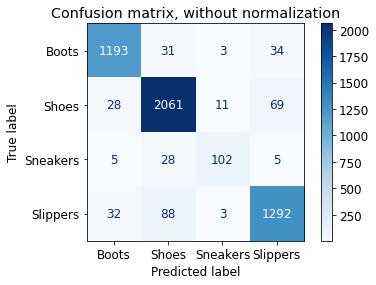

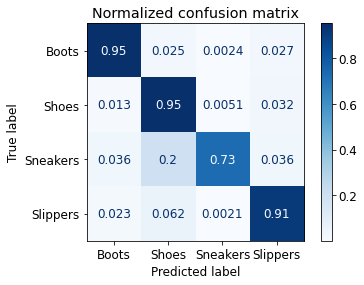

In [ ]:
#hide
class_names = df.Category.unique()

for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf_log, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.savefig('log_Matrix2.png')

# Part 3: full transfer learning.  re-tune MobileNet_vt to classify my data

In [ ]:

# some helper functions.
def get_x(r): return path_images/r['path']
def get_y(r): return r['Category']
def splitter(df):
    train = df.index[df['train']].tolist()
    valid = df.index[df['validate']].tolist()
    return train,valid

In [ ]:
batch_tfms=Normalize.from_stats(*imagenet_stats)

tfms = aug_transforms(mult=1.0, 
               do_flip=True, 
               flip_vert=False, 
               max_rotate=5.0, 
               min_zoom=1.0, 
               max_zoom=1.05, 
               max_lighting=0.1, 
               max_warp=0.05, 
               p_affine=0.75, 
               p_lighting=0.0, 
               xtra_tfms=None, 
               size=None, 
               mode='bilinear', 
               pad_mode='reflection', 
               align_corners=True, 
               batch=False, 
               min_scale=1.0)

# put everythign in train, and don't do any augmentation since we are just going 
# resize to 160
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   splitter=splitter, 
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms=Resize(160,method='pad', pad_mode='border'),
                   batch_tfms=tfms)  # border pads white...

In [ ]:
dls = dblock.dataloaders(df,bs=64,drop_last=False)

In [ ]:
mobilenet_split = lambda m: (m[0][0][10], m[1])

learn = cnn_learner(dls, models.mobilenet_v2, splitter=mobilenet_split,cut=-1, pretrained=True,metrics=error_rate)
#learn = cnn_learner(dls, model_conv, splitter=mobilenet_split,cut=-1, pretrained=True)

(0.00043651582673192023, 2.0892961401841603e-05)

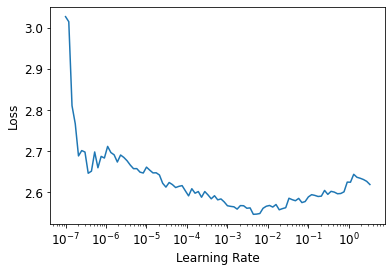

In [ ]:
lr_min,lr_steep = learn.lr_find()
lr_min, lr_steep

In [ ]:
doc(learn.fine_tune)

In [ ]:
learn.predict(dls.dataset[10][0])


learn.fine_tune()

epoch,train_loss,valid_loss,time
0,2.521791,2.044415,00:48
1,2.600940,2.033086,00:49
2,2.579694,2.024415,00:48
3,2.568022,2.053141,00:49
4,2.577766,2.041003,00:48
5,2.585130,2.015271,00:49


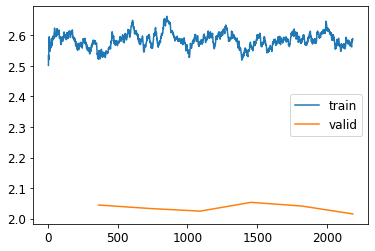

In [ ]:
learn.fit_one_cycle(6, lr_max=1e-5)

learn.recorder.plot_loss()

In [ ]:
#export
def transfer_learner_mobilenet_v2(num_categories):
    model_conv = torchvision.models.mobilenet_v2(pretrained=True)
    for param in model_conv.parameters():
        param.requires_grad = False
    # Parameters of newly constructed modules have requires_grad=True by default
    # just read this off: model_conv.classifier
    num_ftrs = model_conv.classifier._modules['1'].in_features
    model_conv.classifier._modules['1'] = nn.Linear(num_ftrs, num_categories)
    
    return model_conv

In [ ]:
num_categories = 4
model = transfer_learner_mobilenet_v2(num_categories)

# Do Train Test Splits


In [ ]:
import os
from glob import iglob
from os.path import join,basename
import shutil
import random

# UPDATE - JAH, put all data into DATABASE 

data_path = './sneaks/data/' # path of the data
train_path = './train'
test_path = './test'
ldata_path = './data'
val_path = './validate'

df.loc[:,'train'] = 1
df.loc[:,'test'] = 0 
df.loc[:,'validate'] = 0 


In [ ]:
## cat = df['path_and_file']

df.path_and_file.head(5)

0     [Shoes, Oxfords, Bostonian, 100627.72.jpg]
1    [Shoes, Oxfords, Bostonian, 100627.255.jpg]
2     [Shoes, Oxfords, Bostonian, 100657.72.jpg]
3    [Shoes, Oxfords, Bostonian, 100657.216.jpg]
4       [Boots, Mid-Calf, Durango, 101026.3.jpg]
Name: path_and_file, dtype: object

In [ ]:
#for file in iglob(join(data_path,'*')):
#for file( in iglob(join(train_path,'*')):


In [ ]:
if not os.path.exists(ldata_path):


    # create full set
    print('_'*30)
    print('Creating full local category set....')
    print('_'*30)


    for idx in df.index:
        save_path = join(ldata_path,df.loc[idx,'CategoryDir'])

        #print(save_path)
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        img =  join(data_path,df.loc[idx,'path'])
        #print(img)
        shutil.copy2(img,save_path)
                 

In [ ]:
# create test set
print('_'*30)
print('Creating full train set....')
print('_'*30)

for idx in df.index:
    save_path = join(train_path,df.loc[idx,'CategoryDir'])
    #print(save_path)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    img =  join(data_path,df.loc[idx,'path'])
    #print(img)
    shutil.copy2(img,save_path)
            

______________________________
Creating full train set....
______________________________


In [ ]:
# create test set
print('_'*30)
print('Creating test set....')
print('_'*30)

#instead of looking at the files, lets just use the database

for file in iglob(join(train_path,'*')):
#for file in df.path:
    save_path = join(test_path, basename(file))

    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    total_imgs = [x for x in iglob(join(file,'*'))]

    rand_amt = 2* 0.12 * len(total_imgs)  # select 24% of data from each category as testing + validation set
    print(rand_amt)
    test_imgs= []
    for i in range(int(rand_amt)):
        img = random.choice(total_imgs)
        if img not in test_imgs:
            #print(img)
            df.loc[df.Filename == basename(img),'train'] = 0
            df.loc[df.Filename == basename(img),'test'] = 1
            shutil.move(img,save_path)
            test_imgs.append(img)
        
        

______________________________
Creating test set....
______________________________
2264.16
3469.68
2492.88


In [ ]:
# create validation set
print('_'*30)
print('Creating validation set....')
print('_'*30)

#instead of looking at the files, lets just use the database
for file in iglob(join(test_path,'*')):
#for file in df.path:
    save_path = join(val_path, basename(file))

    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    total_imgs = [x for x in iglob(join(file,'*'))]

    rand_amt = 0.5 * len(total_imgs)  # select 50% of data from each category to split evenly between test and validation
    print(rand_amt)
    test_imgs= []
    for i in range(int(rand_amt)):
        img = random.choice(total_imgs)
        if img not in test_imgs:
            #print(img)
            df.loc[df.Filename == basename(img),'test'] = 0
            df.loc[df.Filename == basename(img),'validation'] = 1
            shutil.move(img,save_path)
            test_imgs.append(img)
        
            

______________________________
Creating validation set....
______________________________
1019.0
1538.5
1101.5


In [ ]:
        
# # create valisation set
# print('_'*30)
# print('Creating validation set....')
# print('_'*30)
      
# #instead of looking at the files, lets just use the database
# for file in iglob(join(train_path,'*')):
#             #for file in df.path:
#     save_path = join(val_path, basename(file))

#     if not os.path.exists(save_path):
#         os.makedirs(save_path)
    
#     total_imgs = [x for x in iglob(join(file,'*'))]

#     rand_amt = 0.12 * len(total_imgs)  # select 12% of data from each category as testing set
#     print(rand_amt)

        
        

In [ ]:

      
# save the simple file
summary_file ='train_test_val_Feb-06-2020.pkl'
df.to_pickle(summary_file)

summary_file ='train_test_val_Feb-06-2020.json'
df.to_json(summary_file)  

        

In [ ]:

# save the simple file
summary_file ='train_test_val_Feb-06-2020.pkl'

df.to_pickle(summary_file)

summary_file ='train_test_val_Feb-06-2020.json'
df.to_json(summary_file)



In [ ]:
sum(df.train)

31218

In [ ]:
chg.unique()

array([1, 0])

# simplify data set to only include shoes and boots

In [ ]:
sum(df['Gender']=='Men;Boys;Women;Girls')  # ignore 

4

In [ ]:
df.loc[:,'Sneakers'] = df['SubCategory.Sneakers.and.Athletic.Shoes'] == 1
df.loc[:,'Boots'] = (df.Category1 == 'Boots')
df.loc[:,'Shoes'] = (df.Category1 == 'Shoes') & (~df.Sneakers)#remove 
############
#remove ([ 'Boys',  'Boys;Girls', 'Girls','Women;Girls', 'Men;Boys;Women;Girls', nan
mens =  df['Gender'] == 'Men'       
womens =  df['Gender'] == 'Women' 
etc =  df['Gender'] =='Men;Women' 
df.loc[:, 'Adult'] = mens | womens | etc

## split shoes into athletic and "other"
## remove kids

In [ ]:
# make some expository columns 
#keep Adult, Sneakers, Boots, Shoes

keep_rows = (df.Sneakers | df.Boots | df.Shoes) & (df.Adult)



keep_columns = ['CID',
                 'Category',
                 'SubCategory',
                 'Gender',
                 'path',
                 'Sneakers',
                 'Boots',
                 'Shoes',
                 'path_and_file',
                 'Brand',
                 'Filename',
                 'image_features']


df = df.loc[df.index.intersection(keep_rows),:]

In [ ]:
df = df.filter(items=keep_columns)
df.tail()

In [ ]:
df


,CID,Category,SubCategory,Gender,path,Sneakers,Boots,Shoes,path_and_file,Brand,Filename
15747,7841044-325,Shoes,Loafers,Men,Shoes/Loafers/RJ Colt/7841044.325.jpg,False,False,True,"[Shoes, Loafers, RJ Colt, 7841044.325.jpg]",RJ Colt,7841044.325.jpg
15748,7841047-3,Shoes,Oxfords,Men,Shoes/Oxfords/RJ Colt/7841047.3.jpg,False,False,True,"[Shoes, Oxfords, RJ Colt, 7841047.3.jpg]",RJ Colt,7841047.3.jpg
15749,7841047-6,Shoes,Oxfords,Men,Shoes/Oxfords/RJ Colt/7841047.6.jpg,False,False,True,"[Shoes, Oxfords, RJ Colt, 7841047.6.jpg]",RJ Colt,7841047.6.jpg
15750,7841050-144,Boots,Mid-Calf,Boys;Girls,Boots/Mid-Calf/Old West Kids Boots/7841050.144...,False,True,False,"[Boots, Mid-Calf, Old West Kids Boots, 7841050...",Old West Kids Boots,7841050.144.jpg
15751,7841051-559,Boots,Knee High,Girls,Boots/Knee High/Old West Kids Boots/7841051.55...,False,True,False,"[Boots, Knee High, Old West Kids Boots, 784105...",Old West Kids Boots,7841051.559.jpg
...,...,...,...,...,...,...,...,...,...,...,...
50020,8168300-128,Shoes,Heels,Women,Shoes/Heels/J. Renee/8168300.128.jpg,False,False,True,"[Shoes, Heels, J. Renee, 8168300.128.jpg]",J. Renee,8168300.128.jpg
50021,8168300-742,Shoes,Heels,Women,Shoes/Heels/J. Renee/8168300.742.jpg,False,False,True,"[Shoes, Heels, J. Renee, 8168300.742.jpg]",J. Renee,8168300.742.jpg
50022,8168300-57113,Shoes,Heels,Women,Shoes/Heels/J. Renee/8168300.57113.jpg,False,False,True,"[Shoes, Heels, J. Renee, 8168300.57113.jpg]",J. Renee,8168300.57113.jpg
50023,8168300-384413,Shoes,Heels,Women,Shoes/Heels/J. Renee/8168300.384413.jpg,False,False,True,"[Shoes, Heels, J. Renee, 8168300.384413.jpg]",J. Renee,8168300.384413.jpg


# Part 2:  Sneaker Finder 1.0

# Part 3:  Sneaker Gen (Sneaker Finder 2.0)

# Part 4:  iteration 1.



Zappos 50k MobileNetV2 transfer learing

In [ ]:
# misnomer... don't actually have features yet...
# save the simple file
summary_file = f'./categories_with_features_{today:%b-%d-%Y}.pkl'
df.to_pickle(summary_file)

summary_file = f'./categories_with_features_{today:%b-%d-%Y}.json'
df.to_json(summary_file)



In [ ]:
# save the simple file
summary_file ='train_test_val_Jun-25-2020.pkl'
#df.to_pickle(summary_file)

json_summary_file ='train_test_val_Jun-25-2020.json'
#df.to_json(summary_file)  
df2 = pd.read_json(json_summary_file)

df = pd.read_json('categories_with_features_Jun-25-2020.json')

        

In [ ]:
df.path_and_file


0               [Shoes, Oxfords, Bostonian, 100627.72.jpg]
1              [Shoes, Oxfords, Bostonian, 100627.255.jpg]
2               [Shoes, Oxfords, Bostonian, 100657.72.jpg]
3              [Shoes, Oxfords, Bostonian, 100657.216.jpg]
4                 [Boots, Mid-Calf, Durango, 101026.3.jpg]
                               ...                        
50020            [Shoes, Heels, J. Renee, 8168300.128.jpg]
50021            [Shoes, Heels, J. Renee, 8168300.742.jpg]
50022          [Shoes, Heels, J. Renee, 8168300.57113.jpg]
50023         [Shoes, Heels, J. Renee, 8168300.384413.jpg]
50024    [Shoes, Sneakers and Athletic Shoes, Travis Ma...
Name: path_and_file, Length: 34278, dtype: object

In [ ]:
df.loc[:,'CategoryDir'] = 'Shoes'
df.loc[df.Boots==1,'CategoryDir'] = 'Boots'
df.loc[df.Sneakers==1,'CategoryDir'] = 'Sneakers'

In [ ]:
      
# save the simple file
summary_file ='train_test_val_Feb-06-2020.pkl'
#df.to_pickle(summary_file)

json_summary_file ='train_test_val_Feb-06-2020.json'
#df.to_json(summary_file)  
df2 = pd.read_json(json_summary_file)

df = pd.read_json('categories_with_features_Feb-05-2020.json')

        

# this fits the models

# Transfer learning with a pretrained ConvNet
Lets try two ways to customize a pretrained model:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. Simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.
We will not (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

1. Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

General machine learning workflow:

1. Examine and understand the data
1. Build an input pipeline, in this case using Keras ImageDataGenerator
1. Compose the model
   * Load in the pretrained base model (and pretrained weights)
   * Stack the classification layers on top
1. Train the model
1. Evaluate model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler,EarlyStopping
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt
from tensorflow.keras.models import load_model
from os.path import isfile

In [ ]:
from tensorflow.keras.applications import VGG16,VGG19
from tensorflow.keras.models import Model
#from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
import os




def no_transfer_model(num_classes,input_shape):
    '''Implementation of vgg11 architecture '''

    X_in = Input(input_shape)
    X = Conv2D(64,3,activation='relu',padding='same')(X_in)
    X = MaxPool2D(pool_size=(2,2))(X)
    X = Conv2D(128,3,activation='relu',padding='same')(X)
    X = MaxPool2D(pool_size=(2,2))(X)
    X = Conv2D(256,3,activation='relu',padding='same')(X)
    X = Conv2D(256,3,activation='relu',padding='same')(X)
    X = MaxPool2D(pool_size=(2,2))(X)
    X = Conv2D(512,3,activation='relu',padding='same')(X)
    X = Conv2D(512,3,activation='relu',padding='same')(X)
    X = MaxPool2D(pool_size=(2,2))(X)
    X = Conv2D(256,3,activation='relu',padding='same')(X)
    X = Conv2D(512,3,activation='relu',padding='same')(X)
    X = MaxPool2D(pool_size=(2,2))(X)
    X = Flatten()(X)
    X = Dense(4096,activation='relu')(X)
    X = Dropout(0.5)(X)
    X = Dense(4096,activation='relu')(X)
    X_out = Dense(num_classes,activation='softmax')(X)
    model = Model(input = X_in, output = X_out)

    return model



def model(model_name, num_classes, is_transfer, num_freeze_layer, weights_path,input_shape):

#     # vgg16_model
#     conv_base_16 = VGG16(weights='imagenet',include_top=False,input_shape=input_shape)
#     #conv_base_16.summary()


    #graph = tf.compat.v1.get_default_graph()

    if not is_transfer or model_name == 'simple':
        model = no_transfer_model(num_classes,input_shape)
        print('how did i get here')
        return model        
    
    
#     if model_name == 'vgg_16':
#         conv_base_16 = VGG16(weights='imagenet',include_top=False,input_shape=input_shape)
#         model = conv_base_16
#     elif model_name == 'vgg_19':
#         conv_base_19 = VGG19(weights='imagenet',include_top=False,input_shape=input_shape)
#         model = conv_base_19
#     elif model_name == 'mnNet_v2':
#         mobileNet_v2 = MobileNetV2(weights='imagenet',include_top=False,input_shape=input_shape,pooling = 'avg')
#         model = mobileNet_v2
    if model_name == 'mnNet_v2':
        mobileNet_v2 = MobileNetV2(weights='imagenet',include_top=False,input_shape=input_shape,pooling = 'avg')
        model = mobileNet_v2
    # final_model
    #global graph 
    #graph = tf.get_default_graph()
  
    print(model_name) 
    print(weights_path)
    print('------x-x-x-x-x-x---x-xx-x-x-x-xx------')   
    print(input_shape) 

    # freeze the given number of layers
    for layer in model.layers[:num_freeze_layer]:
        layer.trainable = False

    # Adding custom layers # maybe have a problem with the mobileNet_v2 output?
    m_out = model.output

    m_flatten = Flatten()(m_out)
    m_dense = Dense(1024,activation='relu')(m_flatten)
    m_drop = Dropout(0.5)(m_dense)
    m_dense = Dense(1024,activation='relu')(m_drop)
    pred_out = Dense(num_classes,activation='softmax')(m_dense)

    # final_model
    #with graph.as_default():
    #    final_model = Model(input=model.input,output=pred_out)
    final_model = Model(input=model.input,output=pred_out)

    print(final_model.summary())
    return final_model

# these functions set up the data

In [ ]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img,img_to_array
from os.path import isdir,abspath,join
from os import listdir

data_path = './data/' # path of the data
train_path = './train'
test_path = './test'

def load_img_arr(p):
    return img_to_array(load_img(p))


def train_val_generator(
    batch_size, train_path,test_path,target_size=(136,136)):

    gen_tr = _train_generator()
    gen_val = _val_generator()

    sample = apply_to_images_in_subdirs(train_path,load_img_arr,num_per_cls = batch_size)
    sample = np.array(sample)
    gen_tr.fit(sample)
    gen_val.fit(sample)

    gen_tr = init_directory_generator(
        gen_tr,train_path,batch_size,target_size=target_size)

    gen_val = init_directory_generator(
        gen_val,test_path,batch_size,target_size=target_size)

    return gen_tr,gen_val


def _train_generator():
    return ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=180,
        zoom_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='reflect'
    )


def _val_generator():
    return ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True
    )

def apply_to_images_in_subdirs(parent_dir, func, num_per_cls=None, **kwargs):
    results = []
    for cls_dir_name in listdir(parent_dir):
        cls_dir = abspath(join(parent_dir, cls_dir_name))
        r = _apply_to_first_n_in_dir(func, cls_dir, num_per_cls, **kwargs)
        results += r
    return results


def _apply_to_first_n_in_dir(func, dir_, num_per_cls, **kwargs):
    if not isdir(dir_):
        return []
    results = []
    for path in listdir(dir_)[:num_per_cls]:
        abspath_ = abspath(join(dir_, path))
        result = func(abspath_, **kwargs)
        results.append(result)
    return results




def init_directory_generator(
    gen, dir_,batch_size, target_size=(136,136),
    class_mode='categorical',shuffle=True):

    return gen.flow_from_directory(
        dir_,
        class_mode = class_mode,
        batch_size = batch_size,
        target_size = target_size,
        shuffle = shuffle
    )

ModuleNotFoundError: No module named 'keras'

# this fits the models

In [ ]:
model_name ='mnNet_v2' #'vgg_16','vgg_19','mnNet_v2','resnet_152','simple'])
is_transfer=True
num_freeze_layer=5
num_classes=4
weights_path='mnNet_v2_weights_tf.h5'
input_shape=(224,224,3)#(img_width,img_height,img_channel)')
batch_size=32
train_path='./train'
test_path='./test'


# model for traning
tr_model = model(model_name,num_classes,is_transfer, num_freeze_layer,weights_path,input_shape)

# train and test generator
train_gen, val_gen = train_val_generator(batch_size,train_path,test_path)

mnNet_v2
mnNet_v2_weights_tf.h5
------x-x-x-x-x-x---x-xx-x-x-x-xx------
(224, 224, 3)


TypeError: ('Keyword argument not understood:', 'input')